In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader


In [2]:
curr_dir = os.getcwd()
plots_dir = os.path.join(curr_dir,"Plots")

In [3]:
print(os.path.join(curr_dir,'Plots'))

/home/simone/Documents/Neuroscience/Projects/VAEs/Plots


In [4]:
def train_Rt(enc,dec,q,x_data,opt,Rt,N_EPOCHS=500,lr_b = 0.1):
    #Train parameters of VAE specified in `opt`
    history = { "loss" : [],
                "distortion" : [],
                "rate" : [],
                "beta" : [1]   }

    for e in range(N_EPOCHS):
        lav = dav = rav = 0
        beta = history["beta"][-1]
        for x_ in x_data:
            rate = q(enc,x_)
            #distortion = distortion_analytical_linear(x_,enc,dec,q.r_all)
            distortion = distortion_gaussian(x_,enc,dec,tau=0.01)
            loss =  distortion +beta*rate
            opt.zero_grad()
            loss.backward()
            opt.step()
            lav += distortion + rate
            dav += distortion
            rav += rate
        if torch.isnan(loss):
            break;
        history["loss"].append(lav.item()/len(x_data))
        history["rate"].append(rav.item()/len(x_data))
        history["distortion"].append(dav.item()/len(x_data))
        #Update constraint
        beta += lr_b*(history["rate"][-1]-Rt)
        beta = beta if beta>0 else 0
        history["beta"].append(beta)
        print(f'Epoch: {e} ||Rate: {history["rate"][-1]}||',
            f'ELBO:{history["loss"][-1]}||',
            f'Distortion: {history["distortion"][-1]}||Beta = {history["beta"][-1]}')
    history["beta"].pop()
    return history

In [5]:
#Architecture parameters and distributions of stimuli
N = 10
K = 5
M = 100
w = torch.distributions.Categorical(torch.tensor([0.5,0.5,0.5]))
gs = torch.distributions.normal.Normal(torch.Tensor([-2,2,4]),torch.tensor([1,1,0.8]))
p_x = torch.distributions.mixture_same_family.MixtureSameFamily(w,gs)
p_x = torch.distributions.normal.Normal(0,5)
#Training parameters.
#PRE_EPOCHS = 100
N_EPOCHS = 3000
N_SAMPLES =5000
lr = 1e-2
BATCH_SIZE = 100
#Generate dataset
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_test = p_x.sample((10000,))[:,None]
x_tsorted,_ = x_test.sort(dim=0)
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
p_x.entropy()

tensor(3.0284)

In [6]:
#Initialize model parameters
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted,w=2)
#enc.As = torch.nn.Parameter(torch.ones(N)[None,:] + 0.8*np.random.randn(10))
#c_in = enc.cs.clone()
#sigma_in = enc.log_sigmas.clone()
#enc.cs = torch.nn.Parameter(torch.Tensor(np.linspace(x_min,x_max,num=N))[None,:])
q = rate_ising(N)
#q = rate_bernoulli(N)
#x_k = x_fine[random.sample(range(1000),K)]
#q.x_k = torch.nn.Parameter(x_k)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder2n(N,M)
fig,axs = plt.subplots(2,1,figsize=(5,5))
axs[0].plot(x_sorted,torch.exp(p_x.log_prob(x_sorted)).detach())
axs[0].set_xlabel("x (stimulus)")
axs[0].set_ylabel(r"$p(x)$")
#axs[0].plot(h.bin_edges[0:-1],torch.log10(h.hist))
#axs[0].set_xscale("log")
axs[1].plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach(),alpha=0.6,=)
axs[1].set_xlabel("x (stimulus)")
axs[1].set_ylabel(r"$p(r_i=1|x)$")
#axs[1].set_xscale("log")

SyntaxError: invalid syntax (3605499838.py, line 19)

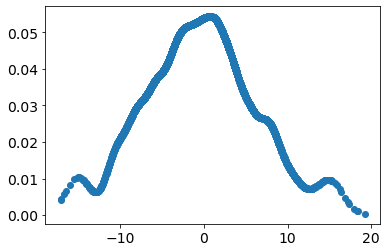

In [58]:
eta = enc(x_test)
I_eta = torch.sigmoid(eta)**2
deta_dx = (x_test - enc.cs)**2/(2*torch.exp(4*enc.log_sigmas))
plt.scatter(x_test,(I_eta*deta_dx).sum(dim=1).detach())

In [59]:
params =   list(enc.parameters()) + list(dec.parameters())  + list(q.parameters())
opt = torch.optim.Adam(params,1e-3)
Rt = 1.5
history = train_Rt(enc,dec,q,x_data,opt,Rt,N_EPOCHS = 3000,lr_b = 0.1)

Epoch: 0 ||Rate: 1.7602511596679689|| ELBO:11.251588134765624|| Distortion: 9.49134033203125||Beta = 1.0260251159667968
Epoch: 1 ||Rate: 1.526261444091797|| ELBO:5.830211181640625|| Distortion: 4.303949890136718||Beta = 1.0286512603759765
Epoch: 2 ||Rate: 1.3726235961914062|| ELBO:4.732896118164063|| Distortion: 3.3602728271484374||Beta = 1.015913619995117
Epoch: 3 ||Rate: 1.2592971801757813|| ELBO:4.284359130859375|| Distortion: 3.0250619506835936||Beta = 0.9918433380126952
Epoch: 4 ||Rate: 1.1721501159667969|| ELBO:3.9807708740234373|| Distortion: 2.8086199951171875||Beta = 0.9590583496093749
Epoch: 5 ||Rate: 1.1045274353027343|| ELBO:3.746112060546875|| Distortion: 2.641584777832031||Beta = 0.9195110931396483
Epoch: 6 ||Rate: 1.0526026153564454|| ELBO:3.5904766845703127|| Distortion: 2.5378741455078124||Beta = 0.8747713546752929
Epoch: 7 ||Rate: 1.011313247680664|| ELBO:3.4905377197265626|| Distortion: 2.4792245483398436||Beta = 0.8259026794433593
Epoch: 8 ||Rate: 0.9779483795166015

In [114]:
#enc3 = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted,w=1)
#enc3.load_state_dict(enc.state_dict())

<All keys matched successfully>

(0.0, 10.0)

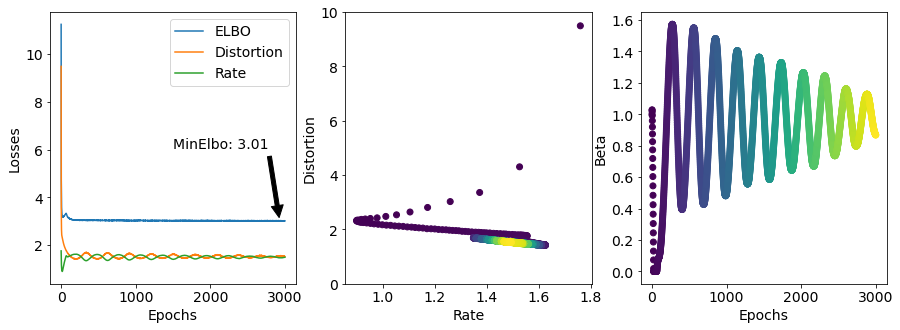

In [60]:
fig,ax = training_plots(history["loss"],history["distortion"],history["rate"],history["beta"])
ax[1].set_ylim(0,10)
#fig.savefig("beta1_training.pdf")

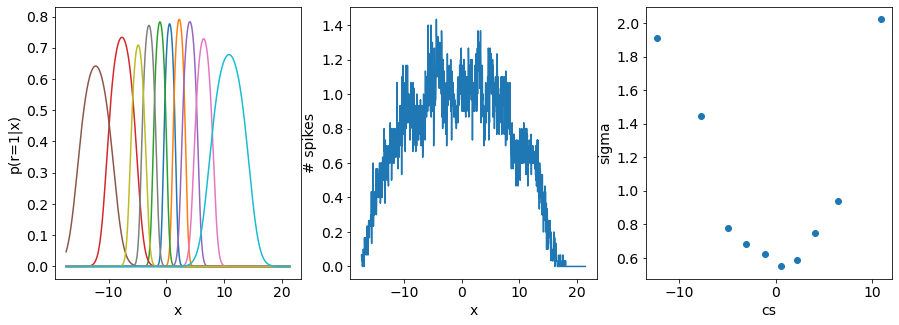

In [61]:
fig,axs = encoder_plots(enc,x_fine)
#axs[0].set_xscale("log")

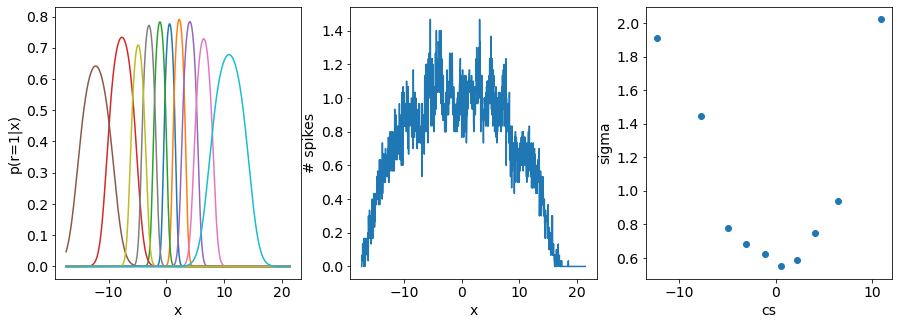

In [62]:
fig,axs = encoder_plots(enc,x_fine)
#axs[0].set_xscale("log")

In [63]:
torch.sigmoid(enc(x_tsorted)).mean(),torch.sigmoid(enc(x_tsorted)).sum()

(tensor(0.0985, grad_fn=<MeanBackward0>),
 tensor(9846.3418, grad_fn=<SumBackward0>))

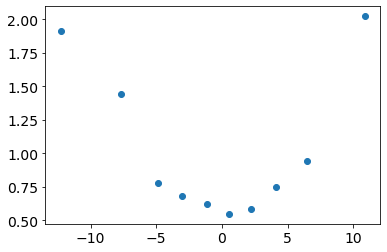

In [64]:
with torch.no_grad():
    plt.scatter(enc.cs, torch.exp(enc.log_sigmas))
    #plt.scatter(enc4.cs, torch.exp(enc4.log_sigmas))
    #plt.ylim(0,8)

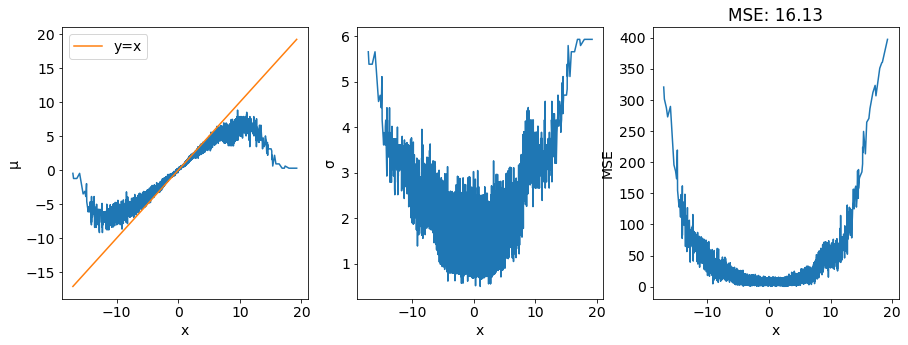

In [65]:
fig,axs,mse = decoder_plots(enc,dec,x_tsorted)
#axs[2].set_xscale("log")
#axs[2].set_yscale("log")
#fig.savefig("beta1_decoder.pdf")

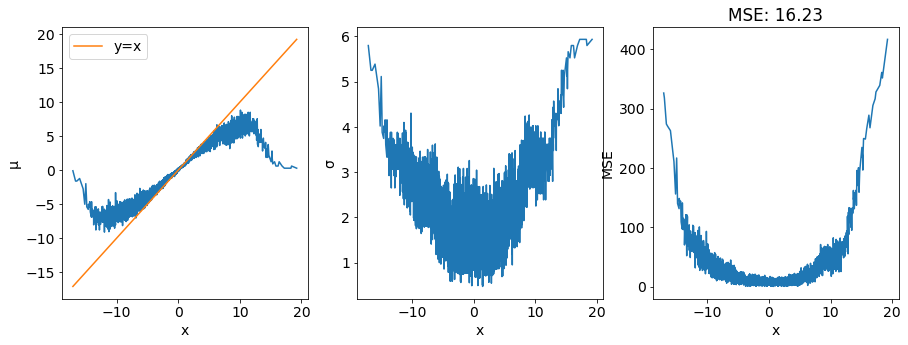

In [66]:
fig,axs,mse = decoder_plots(enc,dec,x_tsorted)

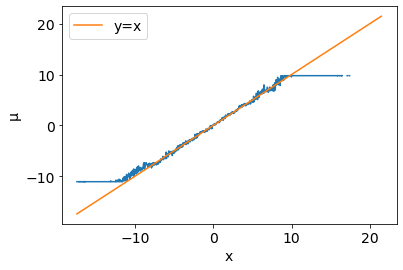

In [67]:
with torch.no_grad():
    r = enc.sample(x_fine,15)
    mu_dec,log_sigma_dec = dec(r)
    mu_dec = torch.where((r.sum(dim=2)) >0,mu_dec.double(),float('nan'))
    x_ext = dec.sample(r,10)
    mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
    fig,axs = plt.subplots()
    axs.plot(x_fine,mu_dec.nanmean(dim=1))
    axs.plot(x_fine,x_fine,label="y=x")
    axs.legend()
    axs.set_xlabel('x')
    axs.set_ylabel('μ')

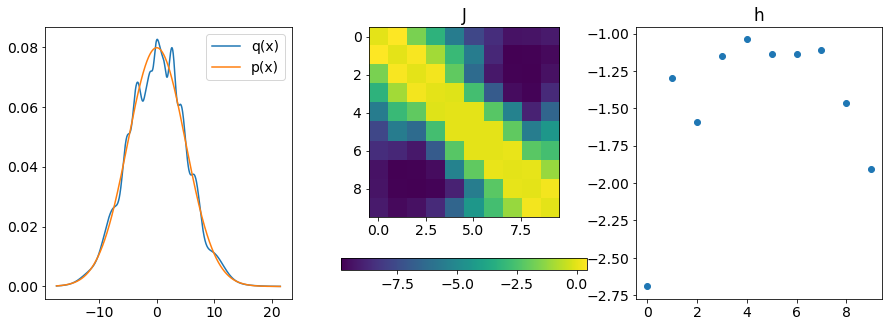

In [68]:
_,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
fig,axs = generative_model_analytical_plots(q,dec,p_x,x_fine,indices)
#axs[0].set_xscale("log")
#fig.savefig("beta1_gm.pdf")

NameError: name 'fs' is not defined

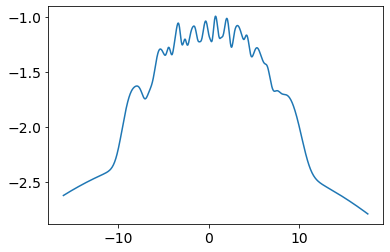

In [19]:
with torch.no_grad():
    mu_dec_all,log_sigma_all = dec(q.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q.h@q.r_all + (q.r_all*(q.J@q.r_all)).sum(dim=0),1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    fig,axs = plt.subplots()
    axs.plot(x_fine,torch.log10(torch.exp(q_x.log_prob(x_fine))),label= "q(x)")
    axs.plot(fs,torch.log10(pf),label= "p(x)")
    axs.legend()
    axs.set_xscale("log")

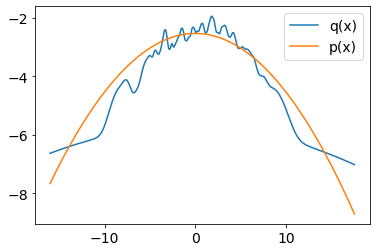

In [20]:
with torch.no_grad():
    mu_dec_all,log_sigma_all = dec(q.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q.h@q.r_all ,1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    fig,axs = plt.subplots()
    axs.plot(x_fine,q_x.log_prob(x_fine),label= "q(x)")
    axs.plot(x_fine,p_x.log_prob(x_fine),label= "p(x)")
    axs.legend()
    #axs.set_xscale("log")

In [222]:
d = torch.distributions.categorical.Categorical(probs = pf)
x = fs[d.sample((100000,))[:,None]]

In [261]:
(pf*np.log(pf)).sum()

tensor(-3.6044)

In [26]:
p_x.entropy()

tensor(1.4189)

In [51]:
l_r_x = enc(x_tsorted)
bsize,N = l_r_x.shape
#ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
eps = torch.rand(bsize,lat_samp,N)
r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)

In [52]:
lat_samp=10
tau=0.01

(0.5, 3.0)

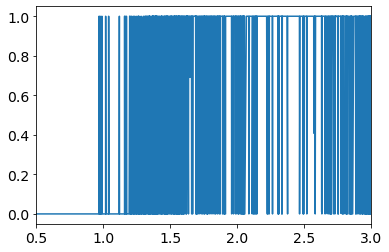

In [53]:
plt.plot(x_tsorted,r[:,1,1].detach())
plt.xlim(0.5,3)